This code has been prouced as a teaching resource for the UKSA space software, data and AI course run by the Space South Central Universities.

Contributors to this code includes: O. Umeh; B. Canning

### Learning Outcome
<div class="alert alert-block alert-info"> 
<b>NOTE</b> In this notebook we will learn how to match open street map data with satelite data and prepare it for a ML process.
</div>

<div class="alert alert-block alert-warning">
This code demos PART 2 of our deep learning project example.
</div>

As per usual we will import some things we might need.

In [39]:
# os to help us find and use our files on our operating system
import os

# Glob will let us handle our file structure on our computer for importing the files we have saved 
import glob

# Numpy for maths
import numpy as np

# Some plotting stuff
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# For open street map we are using osmnx, there are other options as well
import osmnx as ox

# To save the data in geojson format we will use this one
import geojson

# Our friend Geopandas for spatial data manipulations
import geopandas as gpd

# And another friend for API requests
import requests

# This is the earthengine-api package - we will import our satelite data by querying google earth engine
import ee 

# This package will enable us to work efficeintly with gridded raster datasets and vector datasets (important for GIS data type conversions) 
import rasterio 
from rasterio.features import rasterize

# I'm going to filter my regions with a box shape below - you could do other things...
from shapely.geometry import box

# The below are some extras that could help us with plotting and other tasks - we won't specifically use these in the examples
# but you might want to explore some of their options yourself going through the exercises 
import geemap.foliumap as emap # this imports a method of creating interactive maps with geemap
from pyproj import Geod # pyproj helps us work with coordinate transformations and projections (below instead we use geopandas .crs and .cx)

# This one because I only want to see errors not warnings - lazyness that you don't wan ot include when developing 
import logging
logging.getLogger('rasterio').setLevel(logging.ERROR)

In case study 1 we picked Marrakech, Morocco pre and post 8th September 2023 earthquake. 

To continue we have made the decision to change location to Indonesia pre- and post- 2018 earthquake. We have made this decision as some of the damage, for example by resulting mud slides and flooding, is more clear to see by eye on the Sentinel 10m imaging. When developing code you should always find a way to test your code. Visulising it is a basic and good method and this case study is chosen to help you do so easily.

We are picking a 'use case' for our code - in this case we will be interested in identifying buildings pre- and post- earthquake.

There was a 7.5 magnitude earthquake that struck Indonesia on 28 September, 2018.  This quake was very destructive and accompanied by a tsunami, it caused buildings to collapse, landslides and flooding.  For context a summary from ESA can be found here: https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2/Sentinel-2_maps_Indonesia_earthquake

The Copernicus grading map for the Palu location is shown below. 


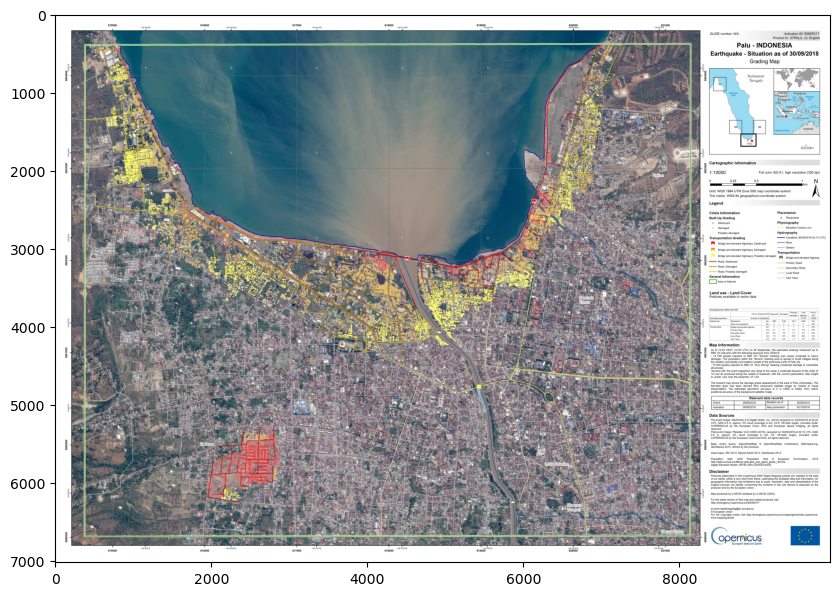

In [3]:
fig, ax = plt.subplots(1, 1,figsize=(10, 10))
ax.imshow(Image.open("Copernicus_grading_map.jpg"))

This sort of code could be useful for taking some key actions following an earthquake, such as:

 * Safety and Assessment: Evaluate the stability of buildings and infrastructure.
 * Allocate resources: Direct assiatnce to areas that are impacted the most.

**Our overall aim will be** to create a dataset using open street map (OSM) polygons to annotate buildings in sentineal-2 imagery. Then we will use the dataset to train an object detector (ML/AI) to detect buildings in an unmapped location.

We will need to deploy steps we have learned in our course are more:

* **NOTE** Think about the data we need and its features (research, consult with a GIS domain expert, consult with a disaster and risk expert etc - these are areas your friendly neiboughood academic can help with)
* **NOTE** Think about how to approach the code and directory structures for your use case, and how and if you want generality in your application, how will you version your software appropriately and ensure that it is not 'broken' by underlying software changes, is it affordable to continue to support software updates or do you need a static solution (research, consult with a computational expert - these are areas your friendly neiboughood academic can help with)
* **NOTE** Do you have other factors in deployment you need to consider e.g. cyber security, is speed of the upmost importance, is accuracy of the upmost importance, is computational power of the upmost importance, will you deploy on the edge, are there ethical considerations to either the data, the algorithm or the deployment, will you have liability? (more areas your friendly neiboughood academic can help with)
  
1. Download data of interest (remember the request package examples..)
2. Save data in a format we want (remember the os and glob package examples..)
3. Read in data of interest (remember the rasterio and glob package examples..)
4. Combine spatial data to create building masks on the same coordinate reference system (remember the geopandas package examples..)
5. Augment the data for generality (multiple ways to do this, can write you own code easily enough but remember that the packages like PyTorch Tensorflow etc. also come with fairly quick, speed optimised solutions...)
6. Write a model or load a pre-trained one (remember how to define your models and all your params and hyperparams which can be tweaked...). Benchmark your models with known datasets. 
7. Train (remember again all the steps here which can be tweaked and optimised...) Benchmark your models with known datasets.
8. Visulise results (how will you know when your metric of 'good enough for my application' has been reached? Remember the key visulation steps...)
9. Test and deploy model (consider again robustness, generailty, cyber security, ethics, speed, power requirements to deply, can it be deployed on all platforms needed, will your model need updating over time?)


Part 1 showed us how to query open street map data and do some of 1., 2., and 3. above. 

By the end of this part of the case study you will be able to do steps from 1. to 5. using both open street map data and sentinel data.

#### Now let's start our little project...

We'll define and area of interest.

This time we'll do so with a place name - remember we have lots of examples of doing so with bounding boxes, point coordinates etc.

<div class="alert alert-block alert-warning">
See our EarthEngineAPI.ipynb for other examples of defining places of interest.
</div>

In [4]:
place_name = "Palu, Indonesia"
area_of_interest = ox.geocode_to_gdf(place_name)

Now we will use OSM to find that place name and to return us a list of tagged 'buildings'

In [5]:
buildings = ox.features_from_place(place_name, tags={"building": True})

We have already learned we should make test plots for **EVERYTHING** for cheacking purposes and to efficiently debug our code. So let's plot the bounding box of this place name and the buildings.

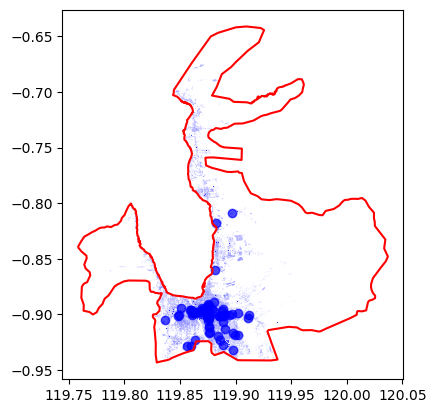

In [6]:
fig, ax = plt.subplots()
area_of_interest.boundary.plot(ax=ax, color="red")
buildings.plot(ax=ax, color="blue", alpha=0.7)
plt.show()

We wish to focus in on a specific region which is the city of Palu - the region with the high density of buildings on the bottom of the figure above. 

We are doing this for two reasons:
* We are training a building classifyer - we should therefore focus on regions around the city where there are many buildings
* This region is fairly large - google earth engine has limits for the amount of data we may download in one http request call - i have already tested this entire area and it would be too large 

<div class="alert alert-block alert-success"> 
 <strong>Exercises</strong>
 <br>
 <li> don't take my word for it - test this out! </li>
 <li> What happens when you enlarge the region of interest? What errors does the code produce? How might you write a code which can deal with these errors in an agile way? </li>
</div>

Let's define a polygon and filter only the buldings in this region.

I will do this using the 'box' function that i imported from the package 'shapely'.

<div class="alert alert-block alert-warning">
See our geopandas_examples.ipynb for other examples of filtering geo spatial datasets.
</div>

In [9]:
polygon = box(119.81, -0.95, 119.93, -0.86)
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=buildings.crs)


Let's plot these on top of each toher and see what this region looks like.

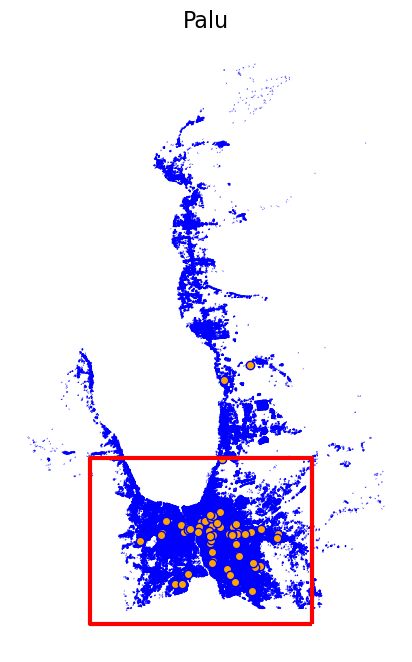

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
buildings.plot(ax=ax1, color='orange', edgecolor='blue', linewidth=1) # here we are changing some defaults
poly_gdf.boundary.plot(ax=ax1, color="red", linewidth=3)
ax1.set_title("Palu", fontsize=16)
ax1.set_axis_off() # what happens if you set these to on or just comment out these lines?
plt.show()


Excellent, I am happy with this region. We are focusing on the region that was displayed in the ESA Copernicus grading map above. This part of the process is purely empirical in this example (it doesn't have to be if you have some criteria which you could code up) and the box was chosen by eye.

Let's now filter our buildigns to be only in this region and similarly we will query the satelite data for only this region too. 

In [10]:
buildings_filtered = buildings.cx[polygon.bounds[0]:polygon.bounds[2], polygon.bounds[1]:polygon.bounds[3]]


And let's plot this once more - remember always find a way to test your code frequently!

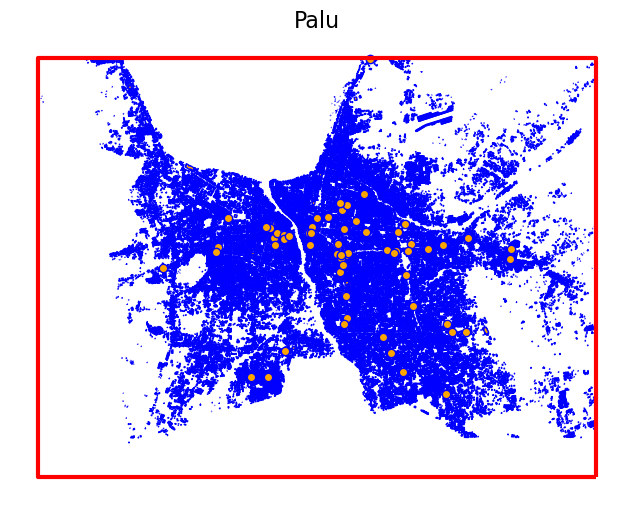

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
buildings_filtered.plot(ax=ax1, color='orange', edgecolor='blue', linewidth=1)
poly_gdf.boundary.plot(ax=ax1, color="red", linewidth=3)
ax1.set_title("Palu", fontsize=16)
ax1.set_axis_off()
plt.show()

Excellent we succedded in filtering the data in the way that we wanted. 

In [12]:
# At this stage we might want to save the building footprints for further use uncomment below to do this
# buildings.to_file("palu_buildings.geojson", driver="GeoJSON")

Let's explore the properties of this 'buildings' geodataframe

In [13]:
#Check the total number of buildings from osm
buildings=buildings_filtered[['geometry']]
print('the number of buildings are: ',len(buildings))

the number of buildings are:  99270


Now just a little bit of jargon whch might be useful to us as we research into things like this...

**Node:** A node represents a single point on the Earth's surface.

**Way:** A way is a sequence of connected nodes that represents a linear feature, such as a road, river, or trail

**Relations** define complex relationships between nodes and ways, representing larger features or areas


In [14]:
# let's take a look at the geodataframe...
print(buildings)

                                                                  geometry
element_type osmid                                                        
node         1559874285                         POINT (119.89063 -0.91325)
             1569892514                          POINT (119.86086 -0.8986)
             1569892542                          POINT (119.85994 -0.8964)
             1569892635                         POINT (119.86146 -0.89752)
             1570101272                          POINT (119.8742 -0.90212)
...                                                                    ...
relation     8774553     POLYGON ((119.88685 -0.90088, 119.88685 -0.900...
             8774554     POLYGON ((119.88355 -0.90078, 119.88355 -0.901...
             8774555     POLYGON ((119.88656 -0.90252, 119.88666 -0.902...
             8774691     POLYGON ((119.89024 -0.90677, 119.89024 -0.906...
             8778619     POLYGON ((119.89098 -0.91127, 119.89073 -0.911...

[99270 rows x 1 columns]

Now a **really important** thing to remember is that we need to make sure all images and datagframes we are working in muct be in the right coordinate systrem. 

Let's work out what the coordinate reference system is for our buildings data at the moment.

<div class="alert alert-block alert-warning">
See our geopandas_examples.ipynb for examples of querying and changing coordinate reference frames.
</div>

In [15]:
buildings.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Getting Sentinnel data for the same region

Having chosen our region, downloaded our 'label' dataset from open street map and then used the data to refine our region choice we are now ready to get Sentinnel data for this same refined region.

<div class="alert alert-block alert-success"> 
 <strong>Exercises</strong>
 <br>
 <li> Note that I started with the open street map data in this case study not the satelite data - why?</li>
</div>


We will use google earth engine API to do this. 

Remember our steps from before:
1. Authenticate yourself
2. Define your request
3. Use requests to make an http request
4. Save data and use rasterio to load it in


<div class="alert alert-block alert-warning">
See our EarthEngineAPI.ipynb for a refresher on querying the google earth engine API for satelite data.
</div>

In [16]:
ee.Authenticate()
ee.Initialize(project="uksa-training-course-materials") # you need to copy here your credentials

Below we will define a path where we wish to store our data. 

In [17]:
# we define the path
#path='/home/jovyan/data/Tutorial_data/scratch/GEE_test/beckycanning/'
path='/Users/beckie/Data/UKSA_course_sandpit/GEE_test/beckycanning/'
# check if the directory already exists
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path) #we create the directory
   print("Created directory!")

Now we are going to reproduce our polygon bounds which defined our region of interest (roi) above in the format which earth engine wants. Remeber all the API's you use will have their own format. Go to their help files for a describtion of what this format is. 

In [19]:
roi = ee.Geometry.BBox(polygon.bounds[0], polygon.bounds[1], polygon.bounds[2], polygon.bounds[3])


Having defined the region of interest to send to google EE API we also need to define the:

* Timescale of interest
* Satelite collection (in this case we want sentinnel 2 imaging - see EarthEngineAPI.ipynb for detail on how to find your collection)
* Bands of interest
* You should choose what to do in the case their are multiple images - do you wnat just one? how will you define that? Do you wnat a mosaic or composite - how should the images be put toegther?
* Do you wnat to reject 'bad' 'quality' data - Define 'quality' (e.g. cloudy)? Define 'bad' (e.g. percentage of coud cover?)?

Consider the issues facy you with regard to timescale around the 'event' - what about season changes inthe landscape - what is important to your use case?

<div class="alert alert-block alert-warning">
See our EarthEngineAPI.ipynb for a refresher on how to find collections and also the sorts of things you could choose to define.
</div>

In [21]:
### defineing the params for ee

# '2018-09-10', '2018-09-27' - indonesia pre 28th Spetmber 2018 

# Define the Sentinel-2 image collection and filter by date and region
collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate('2018-07-01', '2018-09-27') \
    .filterBounds(roi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Filter images with less than 10% cloud cover

# Get the first image from the collection use .first()
# Get the maximum pixels for a composite - google EE defintion use .max()
# Get a mosaic of the images - google EE defintion use .mosaic()
# But perhaps you want a median or mean combined image... all sorts of thigns you could do
#image = collection.first()
#image = collection.max()
image = collection.mosaic()

# Select the desired bands (e.g., B4: Red, B3: Green, B2: Blue for RGB)
image_rgb = image.select(['B4', 'B3', 'B2'])

# Export the image to Google Drive or as a URL
url = image_rgb.getDownloadURL({
    'scale': 10,           # Set the resolution (in meters)
    'region': roi,         # Region of interest to download
    'format': 'GEO_TIFF'
})

Let's save this data as 'pre_' ...

In [22]:
### get the data and save it in our previous path

response = requests.get(url)

file_path = path + 'pre_sentinel.tif'
with open(file_path, 'wb') as fd:
    fd.write(response.content)

glob.glob(path+'*')

['/Users/beckie/Data/UKSA_course_sandpit/GEE_test/beckycanning/pre_sentinel.tif',
 '/Users/beckie/Data/UKSA_course_sandpit/GEE_test/beckycanning/post_sentinel.tif']

Now let's do this same thign for our 'post_' ... image.

In [23]:
### defineing the params for ee

# Define the Sentinel-2 image collection and filter by date and region
collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate('2018-09-28', '2018-10-28') \
    .filterBounds(roi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 15))  # Filter images with less than 10% cloud cover

# Get the first image from the collection use .first()
# Get the maximum pixels for a composite - google EE defintion use .max()
# Get a mosaic of the images - google EE defintion use .mosaic()

#image = collection.first()
#image = collection.max()
image = collection.mosaic()

# Select the desired bands (e.g., B4: Red, B3: Green, B2: Blue for RGB)
image_rgb = image.select(['B4', 'B3', 'B2'])

# Export the image to Google Drive or as a URL
url = image_rgb.getDownloadURL({
    'scale': 10,           # Set the resolution (in meters)
    'region': roi,         # Region of interest to download
    'format': 'GEO_TIFF'
})

In [24]:
### get the data and save it in our previous path

response = requests.get(url)

file_path = path + 'post_sentinel.tif'
with open(file_path, 'wb') as fd:
    fd.write(response.content)

glob.glob(path+'*')

['/Users/beckie/Data/UKSA_course_sandpit/GEE_test/beckycanning/pre_sentinel.tif',
 '/Users/beckie/Data/UKSA_course_sandpit/GEE_test/beckycanning/post_sentinel.tif']

Let's read in the data and query its CRS and plot it.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0716..2.089].


EPSG:4326


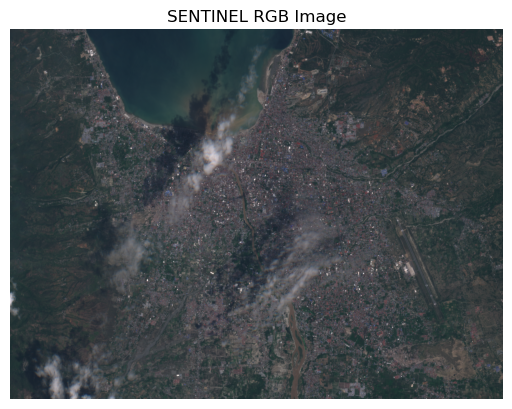

In [25]:
# Read the GeoTIFF file using rasterio
with rasterio.open(path + 'post_sentinel.tif') as src:
    sentinel_image = src.read([1, 2, 3])  # Read the Red, Green, Blue bands
    out_transform = src.transform
    print(src.crs)

sentinel_image_r = np.dstack([sentinel_image[0], sentinel_image[1], sentinel_image[2]])

plt.imshow(sentinel_image_r/5000)
plt.title('SENTINEL RGB Image')
plt.axis('off')
plt.show()

A little cloudy but for this case study we shall live with this...

<div class="alert alert-block alert-success"> 
 <strong>Exercises</strong>
 <br>
 <li> Consider how you might improve this dataset? Write a list of thigns to test.</li>
<li> Try changing the image queries and plot your image to see if you can create a cleaning image - what compromises are you making?</li>
</div>

Now reading in the 'pre_' event image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0558..2.6978].


EPSG:4326


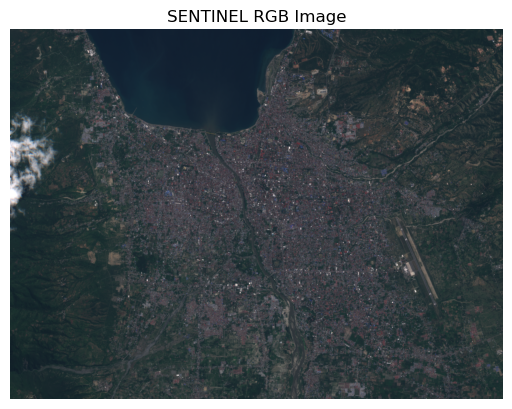

In [67]:
# Read the GeoTIFF file using rasterio
with rasterio.open(path+'pre_sentinel.tif') as src:
    sentinel_image = src.read([1, 2, 3])  # Read the Red, Green, Blue bands
    out_transform = src.transform
    print(src.crs)  

pre_sentinel_image_r = np.dstack([sentinel_image[0], sentinel_image[1], sentinel_image[2]])

plt.imshow(pre_sentinel_image_r/5000)
plt.title('SENTINEL RGB Image')
plt.axis('off')
plt.show()

Now I have two images and a datafranme:

1. Pre_ event image in EPSG:4326
2. Post_ event image in EPSG 4326
3. Buildings geopandas data frame in EPSG 4326

In this case i don't need to do any CRS convresions but if you tried different image combinations above you likley will have got a different coordinate system at some point (e.g. try asking for image.first() from google EE). 

If we were converting our buildings dataframe to another coordinate system we would do this...

In [68]:
#buildings_new_crs = buildings.to_crs("EPSG:32629") - for image.first() whih was not in 4326
buildings_new_crs = buildings.to_crs("EPSG:4326")


Checking it as we should **ALWAYS** check everything.

In [69]:
buildings_new_crs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now that is great but for our ML algorithm we want to provide an image input and a segemntation map with buildings labelled.

Currently we only have one image and essentially a 'table' (dataframe). 

We need ot convert our 'buildings_new_crs' dataframe into an image. 

For this we shall use the rasterio package - let's see what this does below.


Let's first check that our two images are the same size.

In [70]:
print(pre_sentinel_image_r.shape)
print(sentinel_image_r.shape)

# And in only 2D - remember we put our R, G, B images into a stack
print(pre_sentinel_image_r[:,:,0].shape)


(1003, 1337, 3)
(1003, 1337, 3)
(1003, 1337)


And we read in a transformation when we opened the .tif files.

This sets how the image pixels relate to the coordinate reference frame.

In [71]:
out_transform

Affine(8.983152841195215e-05, 0.0, 119.809926410532,
       0.0, -8.983152841195215e-05, -0.8599572214876179)

So let's use the rasterio package to convert our dataframe into an image. 

Really all this package is doing is gridding a list of points into an image. 

![gridding image](gridding.jpg)

<div class="alert alert-block alert-success"> 
 <strong>Exercises</strong>
 <br>
 <li> What are the choices you could make abotu how to 'grid' data?</li>
</div>

In [72]:
# Rasterize geometries to the shape of the Sentinel image
shapes = ((geom, 255) for geom in buildings_new_crs.geometry)

out_shape = pre_sentinel_image_r[:,:,0].shape
rasterized_buildings = rasterize(
    shapes=shapes,
    out_shape=out_shape,
    transform=out_transform,
    fill=0,  # Background value
    all_touched=True,  # To mark any pixel touched by the shape
    dtype=rasterio.uint8
)


Of course let's plot our image to see what happened...

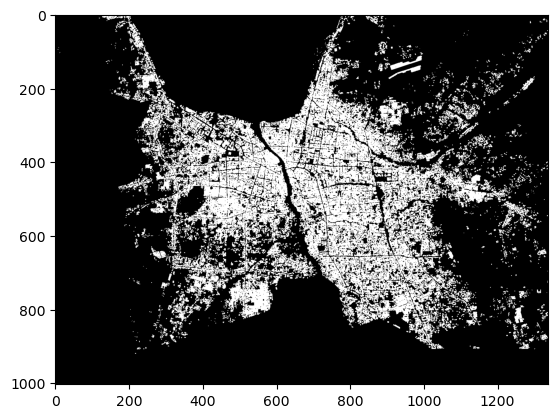

In [73]:
plt.imshow(rasterized_buildings, cmap='gray')
plt.show()

Woop! 

We have an image of buildings which looks vaguely like our satelite imaging.

Let's overplot them and check thigns are actually lined up. 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0716..2.089].


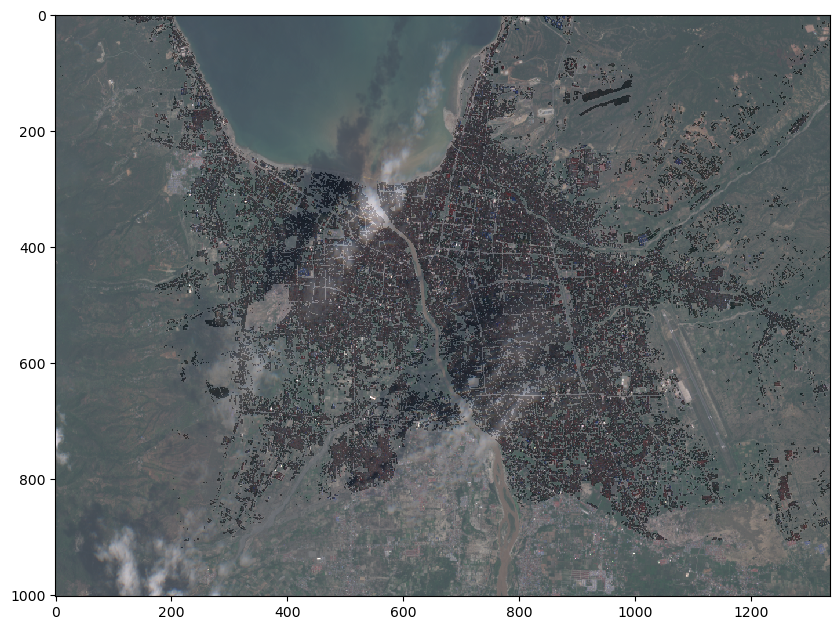

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0558..2.6978].


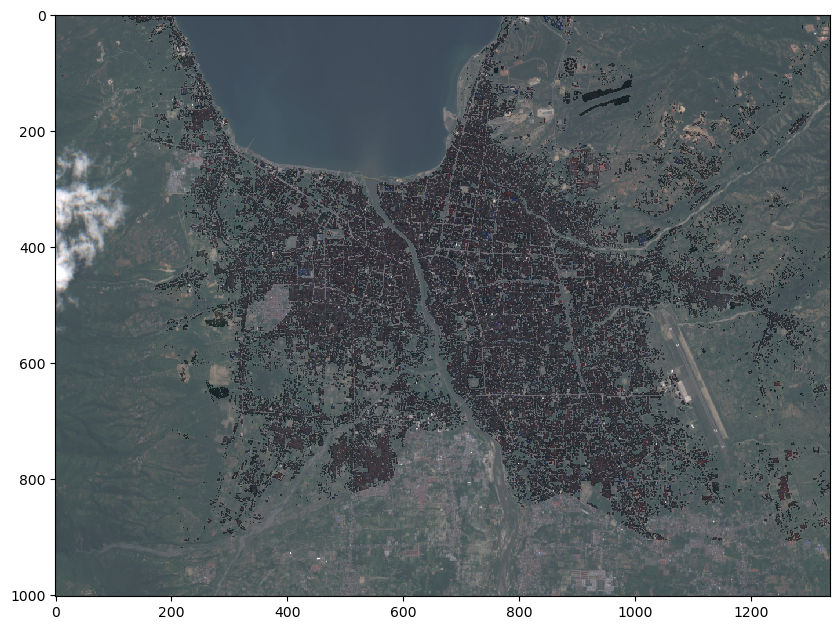

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(sentinel_image_r/5000, cmap='Greys', interpolation='none')
plt.imshow(rasterized_buildings, cmap='Greys', interpolation='none', alpha=0.2)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(pre_sentinel_image_r/5000, cmap='Greys', interpolation='none')
plt.imshow(rasterized_buildings, cmap='Greys', interpolation='none', alpha=0.2)
plt.show()

Now let's zoom into a region of the images, let's see if we can see some differences by eye. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0952..1.1574].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.082..1.1144].


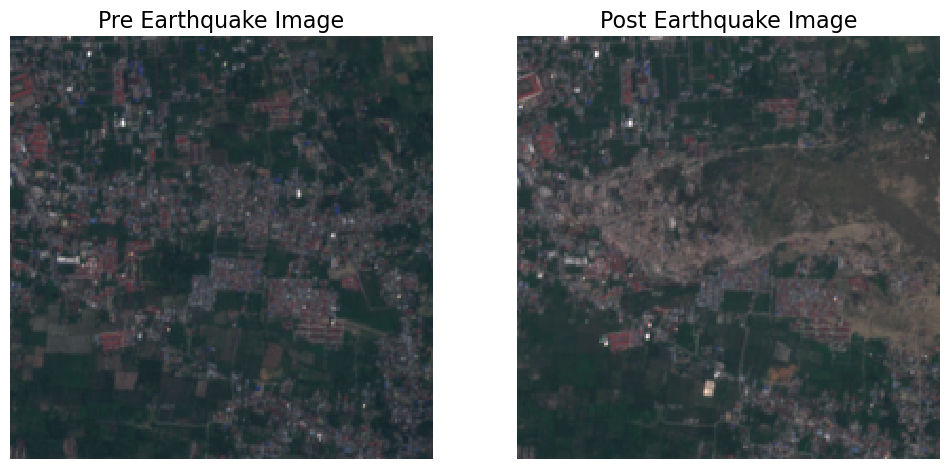

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax2.imshow(sentinel_image_r[800:1000,1000:1200]/5000, interpolation='none')
ax1.imshow(pre_sentinel_image_r[800:1000,1000:1200]/5000, interpolation='none')
ax1.set_title("Pre Earthquake Image", fontsize=16)
ax2.set_title("Post Earthquake Image", fontsize=16)
ax1.set_axis_off() # what happens if you set these to on or just comment out these lines?
ax2.set_axis_off()
plt.show()

We will remember this and use it as a test region - therefore I want to keep this section of the image for testing. 

#### I'm now going to move on to think about how to make my imaging ML ready. 

I am going to create:

1. Train, Verify and Test samples
2. Make sure labels are between 0-1
3. Augment and normalise the data

Now - I learned before that my image size is 1003, 1337 pixels. 

As a first try I will break my images up into 'chunks' of images of 400 pixels. 20 x 20 grids. 

With my 10m per pixel sentinel imaging this is roughly 200m x 200m of land - that should have a good smattering of buildings and land in it. 

I have already found my test sample from above.

Let's start by defeine that.


In [80]:
Testing_image_pre = np.copy(pre_sentinel_image_r[800:1000,1000:1200,:])
Train_verify_image_pre = np.copy(pre_sentinel_image_r)
Train_verify_image_pre[800:1000,1000:1200] = 0

My test region size is by definition 200 x 200 pixels so this will give me 10 x 10 test images once I have broken them up.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.082..1.1144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.6978].


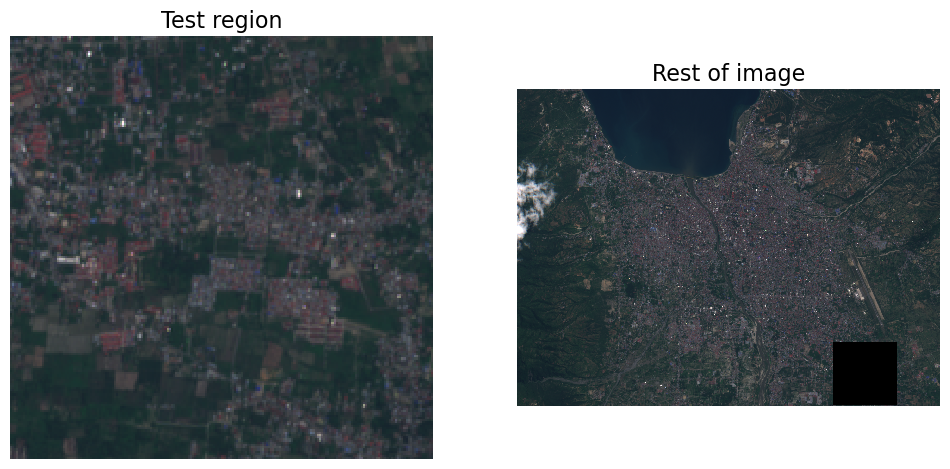

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(Testing_image_pre/5000, interpolation='none')
ax2.imshow(Train_verify_image_pre/5000, interpolation='none')
ax1.set_title("Test region", fontsize=16)
ax2.set_title("Rest of image", fontsize=16)
ax1.set_axis_off() # what happens if you set these to on or just comment out these lines?
ax2.set_axis_off()
plt.show()

An few example 20 x 20 images from my test image could be:

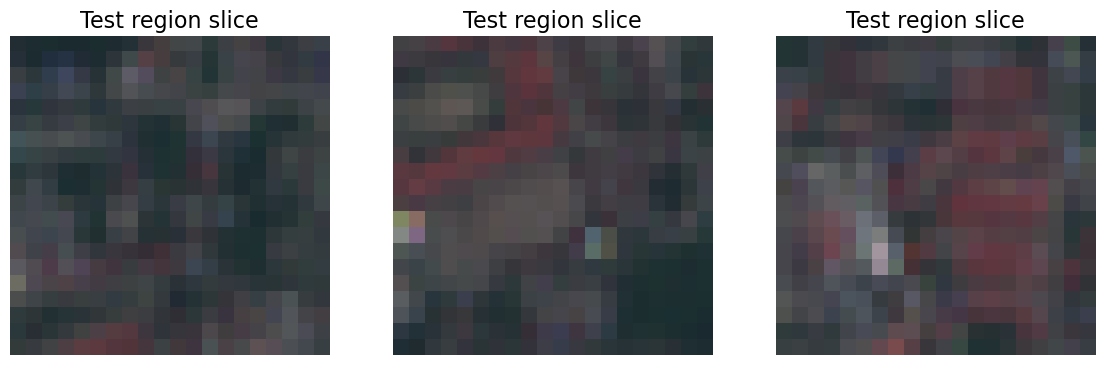

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8))
ax1.imshow(Testing_image_pre[0:20,0:20]/5000, interpolation='none')
ax1.set_title("Test region slice", fontsize=16)
ax1.set_axis_off()
ax2.imshow(Testing_image_pre[20:40,0:20]/5000, interpolation='none')
ax2.set_title("Test region slice", fontsize=16)
ax2.set_axis_off()
ax3.imshow(Testing_image_pre[40:60,0:20]/5000, interpolation='none')
ax3.set_title("Test region slice", fontsize=16)
ax3.set_axis_off()
plt.show()

<div class="alert alert-block alert-success"> 
 <strong>Exercises</strong>
 <br>
 <li> Below is a simple for loop - can you plot the pictures again this time within a loop??</li>
</div>

In [89]:
array=np.linspace(0,2,3)
print(array)
for i in array:
    print('i = ', i)
    print('i * 20 = ', i * 20)

[0. 1. 2.]
i =  0.0
i * 20 =  0.0
i =  1.0
i * 20 =  20.0
i =  2.0
i * 20 =  40.0


We can break up the rest of our image into chunks just like the above. We would then save then into a file structure and these files are the ones we would read in. 

So that is how we do 1. 

1. Train, Verify and Test samples

What about 2 - making sure our labels are between 0 and 1.  Let's define 1 = building from OSM, 0 = other

2. Make sure labels are between 0-1
3. Augment and normalise the data

As a reminder this is our buildings image:

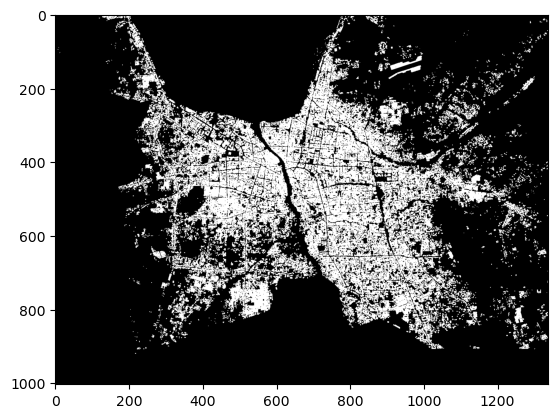

In [90]:
plt.imshow(rasterized_buildings, cmap='gray')
plt.show()

Let's print it and fins out some simple stats about it to understand what the picture shows. 

In [124]:
# first i shall convert it to a numpy array as that is easier to 'do math' on
rb = np.array(rasterized_buildings)
max_image = rb.max()
min_image = rb.min()
print(max_image, min_image)
print('Unique values: ', np.unique(rb))
print(rb.shape)
rb

255 0
Unique values:  [  0 255]
(1003, 1337)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

So our image goes from 0 to 255.  In this case the only values are 0 and 255. 

So to get it between 0 and 1 we will simple divide by 255!

In [125]:
Labels = rb/255

In [127]:
np.unique(Labels)

array([0., 1.])

And the final part of data preparation is to augment and normalise the data..

1. Train, Verify and Test samples
2. Make sure labels are between 0-1

**3. Augment and normalise the data**

<div class="alert alert-block alert-warning">
See our Data_augmentation.ipynb ntoebook for a refresher on augmentation techniques.
</div>

In [128]:
import torchvision.transforms as transforms

We could do this ourselves easily in numpy but let's use pytorch transforms here anyway...

**Note**
I am currently doing this on the non-normalised buildings images - this si becuse in balck and white they are nice and clear to show you and imshow wants images which are 0-255 to display properly. It would be an easy fix to either * by 255 or change imshow colour scale but this is left for you to play with. 

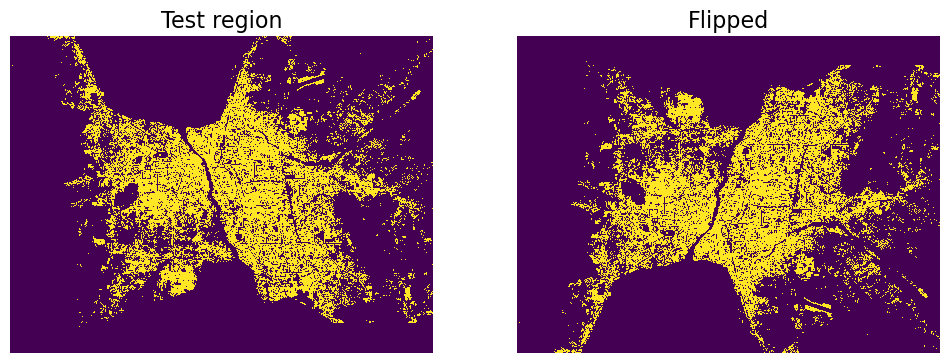

In [132]:
Vertical_Flipping_Transformation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(p=1)
])

new_rb = Vertical_Flipping_Transformation(rb)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(rb, interpolation='none')
ax2.imshow(new_rb, interpolation='none')
ax1.set_title("Test region", fontsize=16)
ax2.set_title("Flipped", fontsize=16)
ax1.set_axis_off() # what happens if you set these to on or just comment out these lines?
ax2.set_axis_off()
plt.show()

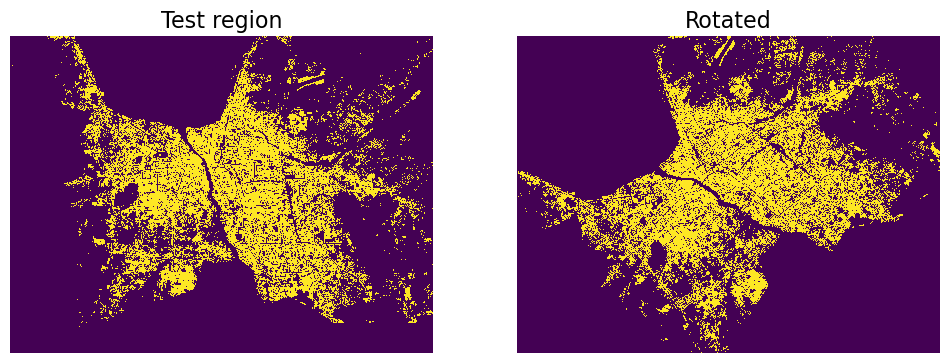

In [131]:
Rotate_Transformation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=(-66,66))
])

new_rb = Rotate_Transformation(rb)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(rb, interpolation='none')
ax2.imshow(new_rb, interpolation='none')
ax1.set_title("Test region", fontsize=16)
ax2.set_title("Rotated", fontsize=16)
ax1.set_axis_off() # what happens if you set these to on or just comment out these lines?
ax2.set_axis_off()
plt.show()

<div class="alert alert-block alert-success"> 
 <strong>Exercises</strong>
 <br>
 <li> Can you now:</li>
 <li> Normalise each band of your data in a simialr way as i normalised the labels set.</li>
 <li> Augment the data as you wish.</li>
 <li> Chunk the data (pre-event image) (and labels!) using a loop and save it into a 'train', 'verify' and 'test' folder.</li>
 <li> We are now ML ready!</li>
 
</div>